In [2]:
import sys
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [3]:
from source.data_processing.cropping import crop_image
from source.visualization.image_visualization import plot_image_with_crop, plot_images_with_matches_via_mapping
import h5py 
from source.data_processing.image_reading import read_image, downscale_image
from source.data_processing.cropping import create_crop_coordinate_mapping
import cv2
from torchvision.transforms import ToTensor
import torch
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.data_processing.keypoints import translate_patch_midpoints_and_refine

from source.loftr.fine_preprocess import FinePreprocess
import matplotlib.pyplot as plt
import numpy as np
from einops.einops import rearrange


Text(0.5, 1.0, 'Image 2')

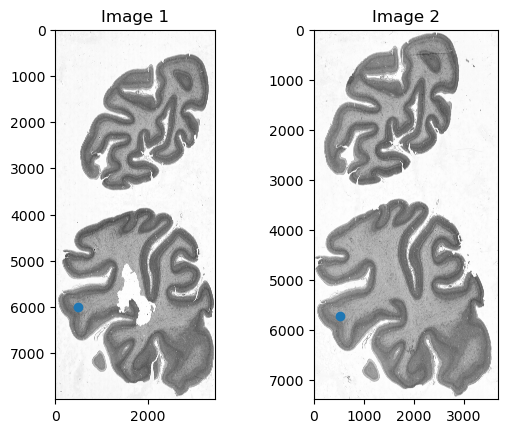

In [4]:
image_1 = read_image(r"C:\Users\robin\Desktop\temp\temp\B20_0524_Slice15.tif", size=(3463, 8000))
image_2 = read_image(r"C:\Users\robin\Desktop\temp\temp\B20_0525_Slice15.tif", size=(3668, 7382))
image_1, image_2 = ToTensor()(image_1), ToTensor()(image_2)

file_path = r"C:\Users\robin\Desktop\temp\temp\0524-0525_deformation_low_scale.h5"
f1 = h5py.File(file_path, 'r')
deformation = cv2.resize(np.array(f1["deformation"])//10, (3463, 8000))
deformation = torch.Tensor(deformation).long()
deformation = torch.flip(deformation, dims=[-1])

index = [6000, 500]

import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot img1_ds_np in the first subplot
axs[0].imshow(image_1[0], cmap='gray')
axs[0].scatter(index[1], index[0])
axs[0].set_title('Image 1')


# Plot img2_ds_np in the second subplot
axs[1].imshow(image_2[0], cmap='gray')
axs[1].scatter(*deformation[index[0], index[1]])
axs[1].set_title('Image 2')

In [4]:
(deformation[:, -1]<0).any(dim=1).nonzero()[-1]

tensor([495])

In [5]:
(deformation[496, :]<0).any(dim=1).nonzero()[-1]

tensor([486])

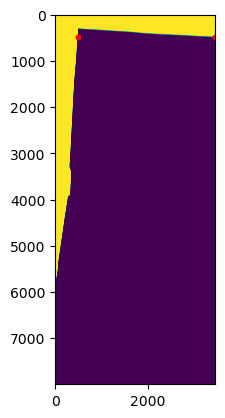

In [6]:
plt.imshow((deformation<0).any(dim=2))
plt.scatter(496, 486, c='r', s=10)
plt.scatter(3462, 486, c='r', s=10)

## Load model

In [59]:
model_name = "lr0p0007_wd0p0015_coarse_contextFalse_img_size3344_3904_ResNet16_4_transform_threshold0p3_temp0p2_bs2_coarse_lossfocal_fine_lossl2_std_trainTrue_gamma1p5_alpha0p55_v3"

confidence_threshold = 0.8

block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).cuda()
backbone.load_state_dict(torch.load(f"../../models/{model_name}/backbone.pt"))


positional_encoding = PositionalEncoding(coarse_feature_size).cuda()

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).cuda()
coarse_loftr.load_state_dict(torch.load(f"../../models/{model_name}/coarse_loftr.pt"))

coarse_matcher = CoarseMatching(temperature=0.1, confidence_threshold=confidence_threshold).cuda()

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=False,
).cuda()

fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).cuda()
fine_loftr.load_state_dict(torch.load(f"../../models/{model_name}/fine_loftr.pt"))


fine_matching = FineMatching(clamp_predictions=True).cuda()

params = list(backbone.parameters()) + list(coarse_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=0.001, lr=0.0008)

In [60]:
crop_size = 640
padding = 50

matches_image_1 = []
matches_image_2 = []
matches_image_2_not_refined = []

with torch.no_grad():
    for y in torch.arange(486+padding, 8000-crop_size-padding, crop_size):
        for x in torch.arange(496+padding, 3463-crop_size-padding, crop_size):
            crop_1 = crop_image(image_1, (x, y), crop_size)

            crop_2_position = deformation[y,x]
            crop_2 = crop_image(image_2, crop_2_position, crop_size)

            crop_coordinate_mapping = create_crop_coordinate_mapping(deformation, 
                                                                    crop_position_image_1=(x, y),
                                                                    crop_position_image_2=crop_2_position,
                                                                    crop_size=crop_size)
            crop_coordinate_mapping = crop_coordinate_mapping.cuda().unsqueeze(0)
            crop_1 = crop_1.cuda().unsqueeze(0)
            crop_2 = crop_2.cuda().unsqueeze(0)

            coarse_image_feature_1, fine_image_feature_1 = backbone(crop_1)
            coarse_image_feature_2, fine_image_feature_2 = backbone(crop_2)

            coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
            coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

            coarse_image_feature_1 = rearrange(
                coarse_image_feature_1, "n c h w -> n (h w) c"
            )
            coarse_image_feature_2 = rearrange(
                coarse_image_feature_2, "n c h w -> n (h w) c"
            )

            coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
                coarse_image_feature_1, coarse_image_feature_2
            )

            coarse_matches_predicted = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)
            match_matrix_predicted = coarse_matches_predicted["match_matrix"]

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
                coarse_image_feature_1=coarse_image_feature_1,
                coarse_image_feature_2=coarse_image_feature_2,
                fine_image_feature_1=fine_image_feature_1,
                fine_image_feature_2=fine_image_feature_2,
                coarse_matches=coarse_matches_predicted,
                fine_height=160,
                coarse_height=40,
            )

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            predicted_relative_coordinates = fine_matching(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            match_matrix_predicted = match_matrix_predicted.cpu()
            predicted_relative_coordinates = predicted_relative_coordinates.cpu()

            crop_1_patch_mid_coordinates, crop_2_patch_mid_coordinates, crop_2_patch_mid_coordinates_refined = translate_patch_midpoints_and_refine(match_matrix=match_matrix_predicted,
                                                                                                                                                    patch_size=16,
                                                                                                                                                    relative_coordinates=predicted_relative_coordinates)
            crop_1_patch_mid_coordinates += torch.Tensor([x, y]).long()
            crop_2_patch_mid_coordinates += crop_2_position
            crop_2_patch_mid_coordinates_refined += crop_2_position

            matches_image_1.append(crop_1_patch_mid_coordinates)
            matches_image_2.append(crop_2_patch_mid_coordinates_refined)
            matches_image_2_not_refined.append(crop_2_patch_mid_coordinates)

            
            # plot_images_with_matches_via_mapping(crop_1, crop_2, crop_coordinate_mapping, 20)
            # plot_image_with_crop(image_1, crop_1, (x, y))
            # plot_image_with_crop(image_2, crop_2, crop_2_position)

            ###########################
            # let loftr predict points between crops
            # add x and y to these so to translate them from crop to image scale
            # save points in global keypoint tensor idk
            ###########################

            # plot_image_with_crop(image_1, crop_1, (x, y))
            # plot_image_with_crop(image_2, crop_2, crop_2_position)

In [61]:
matches_image_1 = torch.concatenate(matches_image_1)
matches_image_2 = torch.concatenate(matches_image_2)
matches_image_2_not_refined = torch.concatenate(matches_image_2_not_refined)
matches_image_1.shape, matches_image_2.shape

(torch.Size([4650, 2]), torch.Size([4650, 2]))

The tensor __matches__ should be of shape (M, 4) where the 4 columns indicating the x,y coordinates of image 1 and 2

In [62]:
# create matches
matches = torch.column_stack((matches_image_1, matches_image_2))
matches_not_refined = torch.column_stack((matches_image_1, matches_image_2_not_refined))

tensor(8.7608)


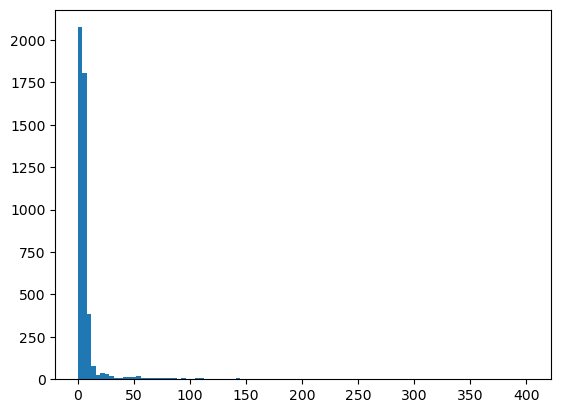

In [63]:
from source.miscellaneous.evaluation import compute_euclidean_distances
print(compute_euclidean_distances(predicted_matches=matches.float(), coordinate_mapping=deformation).mean())
plt.hist(compute_euclidean_distances(predicted_matches=matches.float(), coordinate_mapping=deformation), bins=100)
plt.show()

In [64]:
match_precision = {}
match_precision_not_refined = {}
for pixel_threshold in torch.arange(0, 30, 0.1):
    match_precision[pixel_threshold.item()] = (compute_euclidean_distances(predicted_matches=matches.float(), coordinate_mapping=deformation)<=pixel_threshold).float().mean().item()
    match_precision_not_refined[pixel_threshold.item()] = (compute_euclidean_distances(predicted_matches=matches_not_refined.float(), coordinate_mapping=deformation)<=pixel_threshold).float().mean().item()
    

In [65]:
from source.visualization.evaluation_visualization import plot_precision_vs_threshold

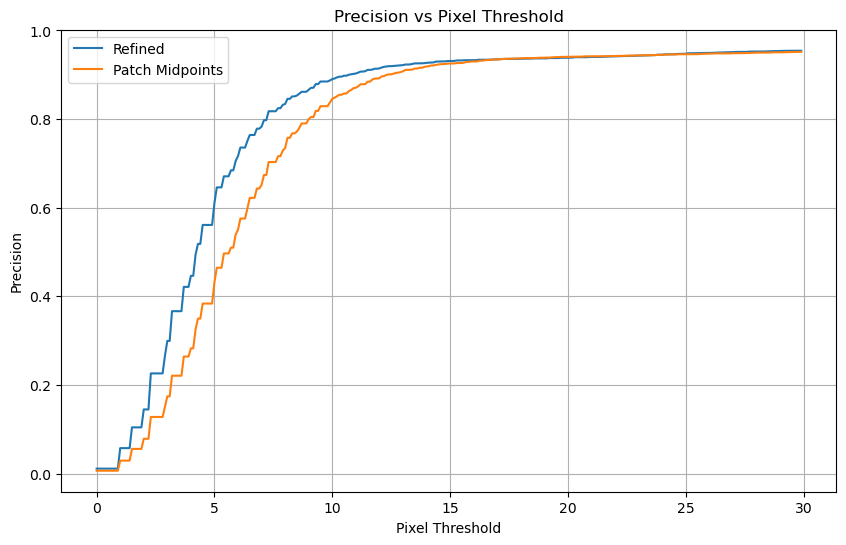

In [66]:
plot_precision_vs_threshold(match_precision, match_precision_not_refined, labels=["Refined", "Patch Midpoints"])

In [77]:
image_1_adjusted = torch.concatenate((image_1, torch.zeros(1, 8000, 205)), dim=2)
image_2_adjusted = torch.concatenate((image_2, torch.zeros(1, 618, 3668)), dim=1)
image_1_adjusted.shape, image_2_adjusted.shape

(torch.Size([1, 8000, 3668]), torch.Size([1, 8000, 3668]))

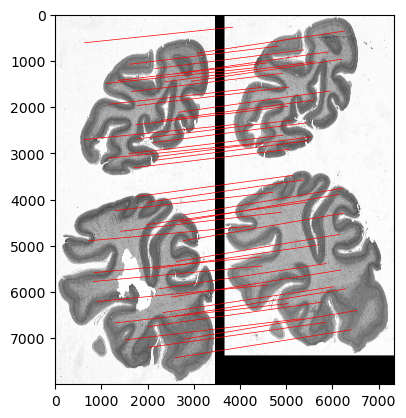

In [78]:
plt.imshow(torch.concatenate([image_1_adjusted[0], image_2_adjusted[0]], dim=1), cmap='gray')
for match in matches[::100]:
    plt.plot([match[0], match[2]+3668], [match[1], match[3]], c='r', linewidth=0.5)

Keypoints found
Matches found
Lenght of matches: 204410


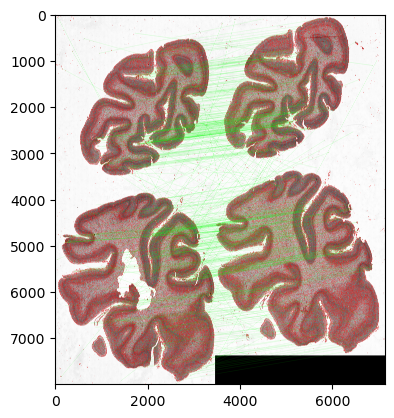

(<matplotlib.image.AxesImage at 0x22b3ff7be90>, None)

In [85]:
import cv2 as cv

image_1_np = image_1[0].cpu().numpy()
image_2_np = image_2[0].cpu().numpy()
image_1_np = (image_1_np*255).astype(np.uint8)
image_2_np = (image_2_np*255).astype(np.uint8)

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(image_1_np,None)
kp2, des2 = sift.detectAndCompute(image_2_np,None)
print("Keypoints found")
# BFMatcher with default params
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)
print("Matches found")
print(f"Lenght of matches: {len(matches)}")

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(image_1_np,kp1,image_2_np,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

In [30]:
matchesMask = torch.Tensor(matchesMask).bool()

In [39]:
matchesMask = torch.Tensor(matchesMask).bool()
sift_matches = []
for index in matchesMask.nonzero()[:, 0]:
    sift_matches.append([*kp1[index].pt, *kp2[index].pt])

In [69]:
matchesMask = torch.Tensor(matchesMask).bool()
sift_matches = []
for test, kp_1, kp_2 in zip(matchesMask, kp1, kp2):
    if test[0]:
        sift_matches.append([*kp_1.pt, *kp_2.pt])

In [73]:
sift_matches = torch.Tensor(sift_matches)
sift_matches.shape

torch.Size([628, 4])

In [75]:
match_precision_sift = {}
for pixel_threshold in torch.arange(0, 600, 1):
    match_precision_sift[pixel_threshold.item()] = (compute_euclidean_distances(predicted_matches=sift_matches, coordinate_mapping=deformation)<=pixel_threshold).float().mean().item()

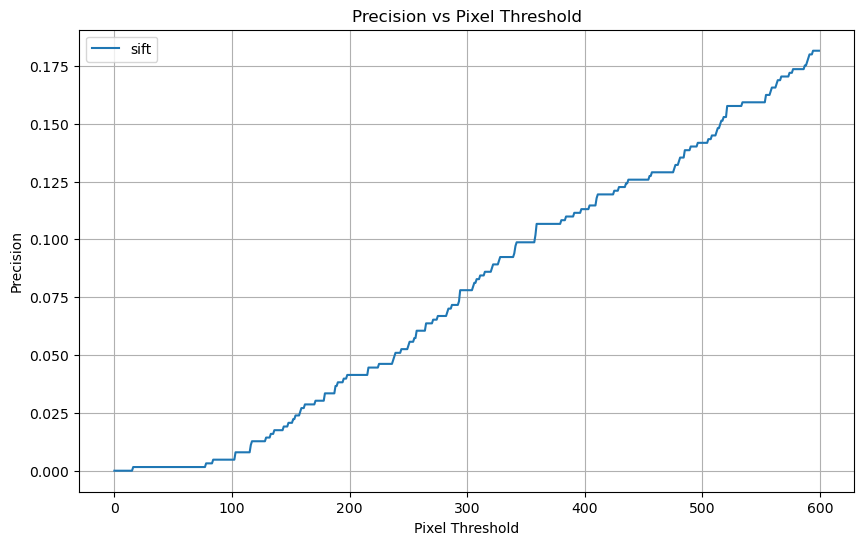

In [76]:
plot_precision_vs_threshold(match_precision_sift, labels=["sift"])

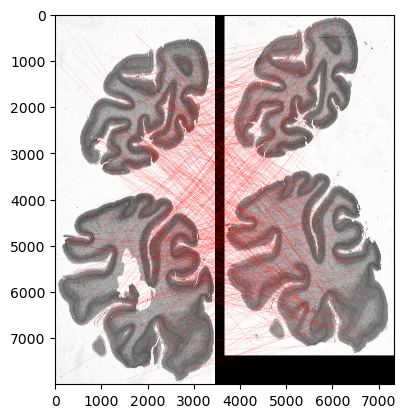

In [83]:
plt.imshow(torch.concatenate([image_1_adjusted[0], image_2_adjusted[0]], dim=1), cmap='gray')
for match in sift_matches:
    plt.plot([match[0], match[2]+3668], [match[1], match[3]], c='r', linewidth=0.1, alpha=0.5)